In [1]:
import os
os.getcwd()

'/Users/zhengyuanrui/Ensemble_oddeven/script'

In [2]:
batch_size=32
epochs = 5

In [3]:
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torch import nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.nn.functional as F
import tqdm
import math
from Model import *
from Myloader import *
from Training import *
from utils import *
from Myloader import *
import matplotlib.pyplot as plt


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
test_path = "../data/test"
val_path = "../data/validation"
train_path = "../data/train"

In [6]:
# transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

In [8]:

custom_dataset = CustomDataset(test_path, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=5, shuffle=True)

In [9]:
images_all, category_label, info_label, idx_info, even_num = next(iter(data_loader ))
print(len(images_all))
print(category_label)
print(info_label)
print(idx_info)
print(even_num)
print(images_all[0].shape)
print(info_label)


2
[tensor([0.5000, 1.0000, 0.5000, 0.0000, 0.5000], dtype=torch.float64), tensor([0.0000, 0.5000, 1.0000, 0.5000, 1.0000])]
tensor([1, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 1])
[tensor([2, 3, 2, 1, 2]), tensor([1, 2, 3, 2, 3])]
torch.Size([5, 1, 56, 56])
tensor([1, 0, 1, 0, 1])


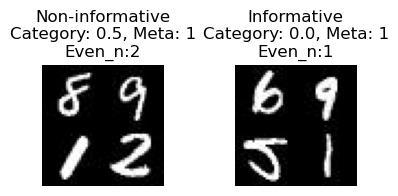

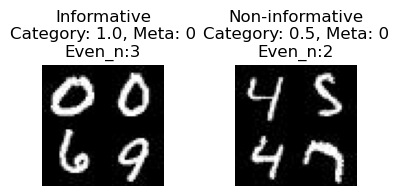

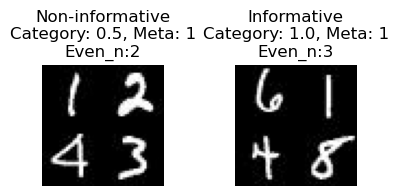

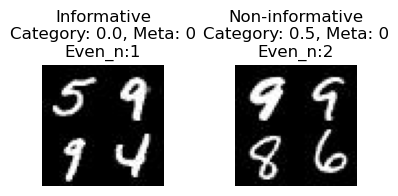

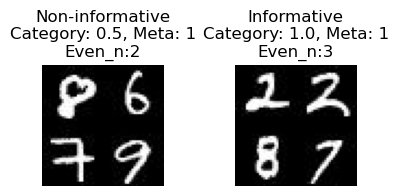

In [10]:

# 使用数据加载器中的数据来可视化图像和标签

# 调用函数显示图像和标签
show_images_labels(images_all, category_label, info_label, idx_info, even_num)


In [ ]:
# test = datasets.ImageFolder(root=test_path, transform=transform) #, target_transform=lambda x: custom_target_transform(test.classes[x])
# test_loader = DataLoader(test, batch_size, shuffle=False)
# val = datasets.ImageFolder(root=val_path, transform=transform)
# val_loader = DataLoader(val, batch_size, shuffle=False)
# train = datasets.ImageFolder(root=train_path, transform=transform)
# train_loader = DataLoader(train, batch_size, shuffle=True)
# from Myloader import data_loader
# class_for_label = {"same":0.5,"odd":0, "even":1 }
#读取数据集
train_dataloader, num_train = data_loader(target_to_oh, train_path, batch_size=32, drop_last=False, shuffle=True)
val_dataloader, num_val = data_loader(target_to_oh, val_path, batch_size=32, drop_last=False, shuffle=True)
test_dataloader, num_test = data_loader(target_to_oh,test_path, batch_size=32, drop_last=False, shuffle=False)


In [ ]:
# Display image and label.
test_features, test_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[5].squeeze()
label = test_labels[5]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [ ]:
train_dataloader.class_to_idx

In [ ]:
model = MyResNet(dropout_prob=0.5).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas = (0.9, 0.999))

In [ ]:
train_loss, val_loss, val_acc, val_roc, model = model_training(epochs=5, model=model, train_loader=train_dataloader, val_loader=val_dataloader, optimizer=optimizer, device=device, loss_fun=F.binary_cross_entropy_with_logits)

In [2]:
from sklearn.metrics import accuracy_score
y_pred = [0, .2, 1, 3]
y_true = [0, 1, .2, 3]
accuracy_score(y_true, y_pred)

ValueError: continuous is not supported